In [311]:
import torch
from data import load_traindata
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
from torch.utils.data import random_split
from scipy.spatial.distance import directed_hausdorff
from augmentation import augment
from scipy.signal import stft, istft
from scipy.signal.windows import hann
import neurokit2 as nk
from models import Critic
from scipy.interpolate import interp1d

mps


WGAN
LSTM
2D Fourier Transform

In [312]:
torch.manual_seed(42)

In [313]:
num_subclasses = 300
epochs = 151
seq_size = 250
batch_size = 32
num_aug = 5
split_size=0.8
lr = 5e-4
input_channel = 4
output_channel = 1

In [314]:
X, _ = load_traindata(num_subclasses)
X = torch.tensor(X, dtype=torch.float32)
X = X.reshape(int(num_subclasses), int(1000 / seq_size), seq_size, 12)
X = X.reshape(int(num_subclasses * int(1000 / seq_size)), seq_size, 12)
train_size = int(split_size*len(X))
test_size = len(X) - train_size
X,X_test = random_split(X,[train_size, test_size])
X = augment(X)
X_input = X[:, :, input_channel]  # First channel
Y_target = X[:, :, output_channel]  # Second channel


X_test_tensors = [X_test.dataset[idx] for idx in range(len(X_test))] 
X_test_tensor = torch.stack(X_test_tensors) 
X_t = X_test_tensor[:, :, 0]  
Y_t = X_test_tensor[:, :, output_channel]

In [315]:
def time_wrap(ecg_data):
    T, C = ecg_data.shape
    warp_factor = np.random.uniform(0.8, 1.2)  # Randomly stretch or compress

    # Create original time indices and new (warped) time indices
    original_time = np.linspace(0, 1, T)
    new_time = np.linspace(0, 1, int(T * warp_factor))

    warped = []
    for c in range(C):
        interp = interp1d(original_time, ecg_data[:, c], kind='linear', fill_value="extrapolate")
        warped_channel = interp(new_time)
        # Resize back to original length to maintain consistent shape
        if len(warped_channel) > T:
            warped_channel = warped_channel[:T]
        else:
            warped_channel = np.pad(warped_channel, (0, T - len(warped_channel)), mode='edge')
        warped.append(warped_channel)

    return np.stack(warped, axis=1)


def time_shifting(ecg_data):
    w = np.random.uniform(0.15, 0.45)
    if not (0 <= w <= 1):
        raise ValueError("w must be between 0 and 1.")
    T = ecg_data.shape[0]
    shift_length = int(w * T)
    # Perform a circular shift (rotation)
    ecg_data = np.roll(ecg_data, shift=shift_length, axis=0)
    return ecg_data
def add_noise(ecg_data):
    noise = np.random.normal(0, 0.005, ecg_data.shape)
    ecg_data += noise
    return ecg_data

def time_masking(ecg_data):
    w = np.random.uniform(0.05, 0.2)
    if not (0 <= w <= 1):
        raise ValueError("w must be between 0 and 1.")
    T = ecg_data.shape[0]
    mask_length = int(w * T)
    ts = np.random.randint(0, T - mask_length + 1)
    ecg_data[ts:ts + mask_length, :] = 0
    return ecg_data

In [316]:
def plotWave_aug(X, text):
    # If input is already numpy, no need for detach or cpu
    x_np = X.squeeze()

    plt.figure(figsize=(10, 4))
    plt.plot(x_np, label=text)
    plt.title("ECG Time Series Augmentation")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()


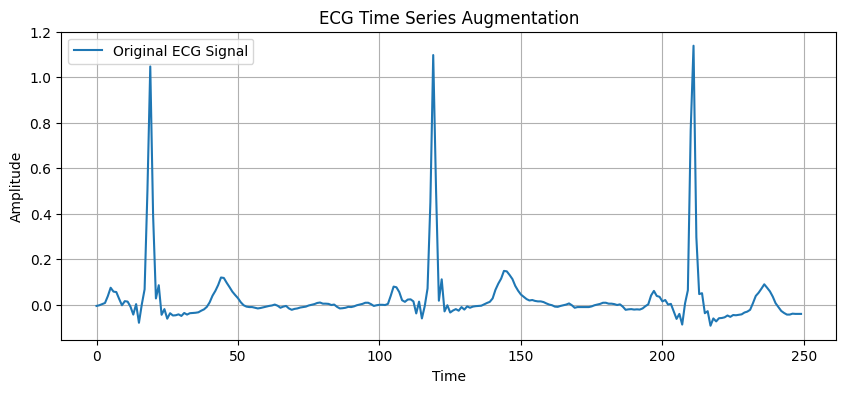

In [317]:
a = X[:,:, 2][0].detach().cpu().numpy()
plotWave_aug(a, "Original ECG Signal")

In [318]:
class Generator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, num_filters=32): 
        super(Generator, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv1d(in_channels, num_filters, 4, 2, 1),  
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv1d(num_filters, num_filters * 2, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 2),
            nn.LeakyReLU(0.2)
        )
        self.enc3 = nn.Sequential(
            nn.Conv1d(num_filters * 2, num_filters * 4, 4, 2, 1), 
            nn.BatchNorm1d(num_filters * 4),
            nn.LeakyReLU(0.2)
        )
        self.enc4 = nn.Sequential(
            nn.Conv1d(num_filters * 4, num_filters * 8, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 8),
            nn.LeakyReLU(0.2)
        )
        self.enc5 = nn.Sequential(
            nn.Conv1d(num_filters * 8, num_filters * 8, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 8),
            nn.LeakyReLU(0.2)
        )
        self.enc6 = nn.Sequential(
            nn.Conv1d(num_filters * 8, num_filters * 8, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 8),
            nn.LeakyReLU(0.2)
        )

        # Decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 8, num_filters * 8, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 8),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 8, num_filters * 8, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 8),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 8, num_filters * 4, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 4),
            nn.ReLU()
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 4, num_filters * 2, 4, 2, 1, output_padding=1),  # 63 → 125
            nn.BatchNorm1d(num_filters * 2),
            nn.ReLU()
        )
        self.dec5 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 2, num_filters, 4, 2, 1),
            nn.BatchNorm1d(num_filters),
            nn.ReLU()
        )
        self.dec6 = nn.ConvTranspose1d(num_filters, out_channels, 4, 2, 1)  
        self.final_activation = nn.LeakyReLU(0.2)  

    def match_size(self, x, target):
        diff = x.size(2) - target.size(2)
        if diff > 0:
            return x[:, :, :-diff]
        elif diff < 0:
            return nn.functional.pad(x, (0, -diff))
        else:
            return x

    def forward(self, x):
        # x shape: (batch_size, 2, seq_len)
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)

        d1 = self.match_size(self.dec1(e6), e5) + e5
        d2 = self.match_size(self.dec2(d1), e4) + e4
        d3 = self.match_size(self.dec3(d2), e3) + e3
        d4 = self.match_size(self.dec4(d3), e2) + e2
        d5 = self.match_size(self.dec5(d4), e1) + e1
        d6 = self.dec6(d5)
        return self.final_activation(d6)

In [319]:
class LSTMGenerator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, num_filters=32):
        super(LSTMGenerator, self).__init__()
        self.seq_size = seq_size

        self.enc1 = nn.Sequential(
            nn.Conv1d(in_channels, num_filters, 4, 2, 1),  # 250 → 125
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv1d(num_filters, num_filters * 2, 4, 2, 1),  # 125 → 63
            nn.BatchNorm1d(num_filters * 2),
            nn.LeakyReLU(0.2)
        )
        self.enc3 = nn.Sequential(
            nn.Conv1d(num_filters * 2, num_filters * 4, 4, 2, 1),  # 63 → 32
            nn.BatchNorm1d(num_filters * 4),
            nn.LeakyReLU(0.2)
        )

        self.lstm = nn.LSTM(num_filters * 4, num_filters * 4, batch_first=True)

        self.flatten = nn.Flatten()

        # Output layer maps to (out_channels * seq_size) = 1 * 250 = 250
        self.output_layer = nn.Linear(3968, out_channels * seq_size)
        self.final_activation = nn.Tanh()

    def forward(self, x):
        e1 = self.enc1(x)                        # [32, 32, 125]
        e2 = self.enc2(e1)                       # [32, 64, 63]
        e3 = self.enc3(e2)                       # [32, 128, 32]

        lstm_input = e3.transpose(1, 2)          # [32, 32, 128]
        lstm_out, _ = self.lstm(lstm_input)      # [32, 32, 128]

        lstm_out = self.flatten(lstm_out)        # [32, 32*128]

        output = self.output_layer(lstm_out)     # [32, 250]

        output = output.view(-1, 1, self.seq_size)  # [32, 1, 250]
        return self.final_activation(output)


In [320]:
# x = real_2[0].cpu().numpy()

# nperseg = 30
# noverlap = 6
# window = hann(nperseg)
# f, t, Zxx = stft(x, window=window, nperseg=nperseg, noverlap=noverlap,
#                  boundary=None, padded=False)

# real_part = np.real(Zxx)
# imag_part = np.imag(Zxx)

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# im0 = axs[0].imshow(real_part, origin='lower', aspect='auto', cmap='plasma')
# axs[0].set_title('Real Part of STFT')
# axs[0].set_xlabel('Time Frames')
# axs[0].set_ylabel('Frequency Bins')
# plt.colorbar(im0, ax=axs[0])
# im1 = axs[1].imshow(imag_part, origin='lower', aspect='auto', cmap='plasma')
# axs[1].set_title('Imaginary Part of STFT')
# axs[1].set_xlabel('Time Frames')
# axs[1].set_ylabel('Frequency Bins')
# plt.colorbar(im1, ax=axs[1])

# plt.tight_layout()
# plt.show()


# _, x_reconstructed = istft(Zxx, window=window, nperseg=nperseg, noverlap=noverlap,
#                            input_onesided=True, boundary=None)

# x_reconstructed = x_reconstructed[:len(x)]
# plt.figure(figsize=(12, 4))
# plt.plot(x, label='Original Signal', alpha=0.7)
# plt.plot(x_reconstructed, '--', label='Reconstructed Signal (iSTFT)', alpha=0.7)
# plt.title("Comparison of Original and Reconstructed Signals")
# plt.xlabel("Time")
# plt.ylabel("Amplitude")
# plt.legend()
# plt.tight_layout()
# plt.show()


In [321]:
class Discriminator(nn.Module):
    def __init__(self, seq_size, num_filters=32):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=num_filters, kernel_size=4, stride=2, padding=1)
        self.leakyRelu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv1d(num_filters, num_filters*2, 4, 2, 1)
        self.bn1 = nn.BatchNorm1d(num_filters*2)
        self.conv3 = nn.Conv1d(num_filters*2, num_filters*4, 4, 2, 1)
        self.bn2 = nn.BatchNorm1d(num_filters*4)
        self.conv4 = nn.Conv1d(num_filters*4, num_filters*8, 4, 2, 1)
        self.bn3 = nn.BatchNorm1d(num_filters*8)
        self.conv5 = nn.Conv1d(num_filters*8, num_filters*8, 4, 2, 1)
        self.bn4 = nn.BatchNorm1d(num_filters*8)
        self.conv6 = nn.Conv1d(num_filters*8, 1, 4, 2, 1)
        self.op = nn.Linear(3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyRelu(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.leakyRelu(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.leakyRelu(x)
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.leakyRelu(x)
        x = self.conv5(x)
        x = self.bn4(x)
        x = self.leakyRelu(x)
        x = self.conv6(x)
        x = self.leakyRelu(x)
        x = x.view(x.size(0), -1)  
        x = self.op(x)
        x = self.sigmoid(x)
        return x

In [322]:
dataset = TensorDataset(X_input, Y_target)
test_dataset = TensorDataset(X_t, Y_t)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
generator = Generator().to(device)
#discriminator = Discriminator(seq_size).to(device)
critic  = Critic(seq_size).to(device)
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0005)
#optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
optimizer_c = torch.optim.AdamW(critic.parameters(), lr=0.0001)
print(sum(p.numel() for p in generator.parameters())/1e6, 'M parameters for Generator')
#print(sum(p.numel() for p in discriminator.parameters())/1e6, 'M parameters for Discriminator')
print(sum(p.numel() for p in critic.parameters())/1e6, 'M parameters for Critic')

1.398145 M parameters for Generator
0.216097 M parameters for Critic


In [323]:
def plot_losses(d_losses, g_losses):
    def smooth_curve(points, factor=0.9):
        smoothed = []
        for point in points:
            if smoothed:
                smoothed.append(smoothed[-1] * factor + point * (1 - factor))
            else:
                smoothed.append(point)
        return smoothed

    plt.plot(smooth_curve(d_losses), label='D Loss')
    plt.plot(smooth_curve(g_losses), label='G Loss')
    plt.legend()
    plt.show()

In [324]:
counter = 0
def plotWave(X, Y, c=0):
    x_np = X.squeeze(0).detach().cpu().numpy()
    y_np = Y.squeeze(0).detach().cpu().numpy()

    # Plotting
    plt.figure(figsize=(20, 6))
    plt.plot(x_np, color='blue', label='X (Generated Signal)')
    plt.plot(y_np, color='red', label='Y (Real Signal)')
    plt.legend()
    plt.title(f'Wave Comparison - Frame {c}')
    plt.show()

    # MSE
    mse = np.mean((x_np - y_np) ** 2)
    # FD
    fd = max(directed_hausdorff(x_np.reshape(-1, 1), y_np.reshape(-1, 1))[0],
             directed_hausdorff(y_np.reshape(-1, 1), x_np.reshape(-1, 1))[0])

    print(f"Frame {c}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Fréchet Distance: {fd:.4f}")

    return c + 1


In [325]:
def l1_loss(x,y):
    return torch.mean(torch.abs(x - y))

In [326]:
def compute_gradient_penalty(critic, real_samples, fake_samples, real_1, device):
    alpha = torch.rand(real_samples.size(0), 1, 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    critic_input = torch.cat([interpolates, real_1], dim=1)
    critic_interpolates = critic(critic_input)
    grad_outputs = torch.ones_like(critic_interpolates).to(device)
    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=critic_input,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

: 

Epoch 1/151, Critic Loss: 0.5602670907974243, Generator Loss: -4.065184593200684
Epoch 2/151, Critic Loss: -0.1614934504032135, Generator Loss: -5.051141738891602
Epoch 3/151, Critic Loss: 0.15554815530776978, Generator Loss: -4.734522342681885
Epoch 4/151, Critic Loss: 0.719624400138855, Generator Loss: -2.0589098930358887
Epoch 5/151, Critic Loss: -1.407989263534546, Generator Loss: 1.9299556016921997
Epoch 6/151, Critic Loss: -1.0050431489944458, Generator Loss: -6.8015265464782715
Epoch 7/151, Critic Loss: -0.2918889820575714, Generator Loss: -2.3642399311065674
Epoch 8/151, Critic Loss: 0.45871078968048096, Generator Loss: -4.616677761077881
Epoch 9/151, Critic Loss: -3.538849115371704, Generator Loss: 2.338885545730591


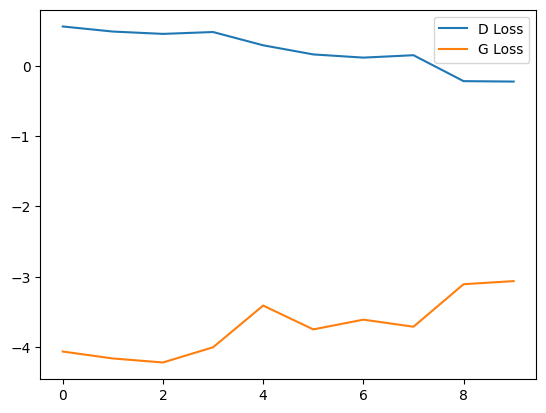

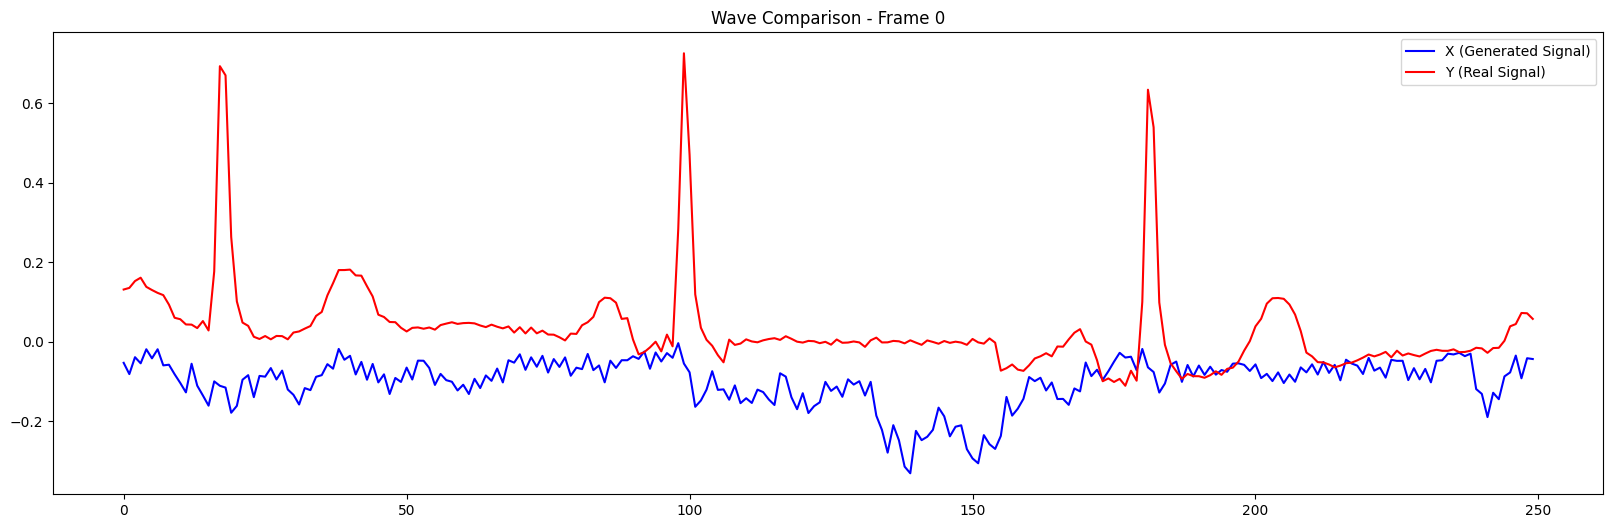

Frame 0:
Mean Squared Error (MSE): 0.0321
Fréchet Distance: 0.7294


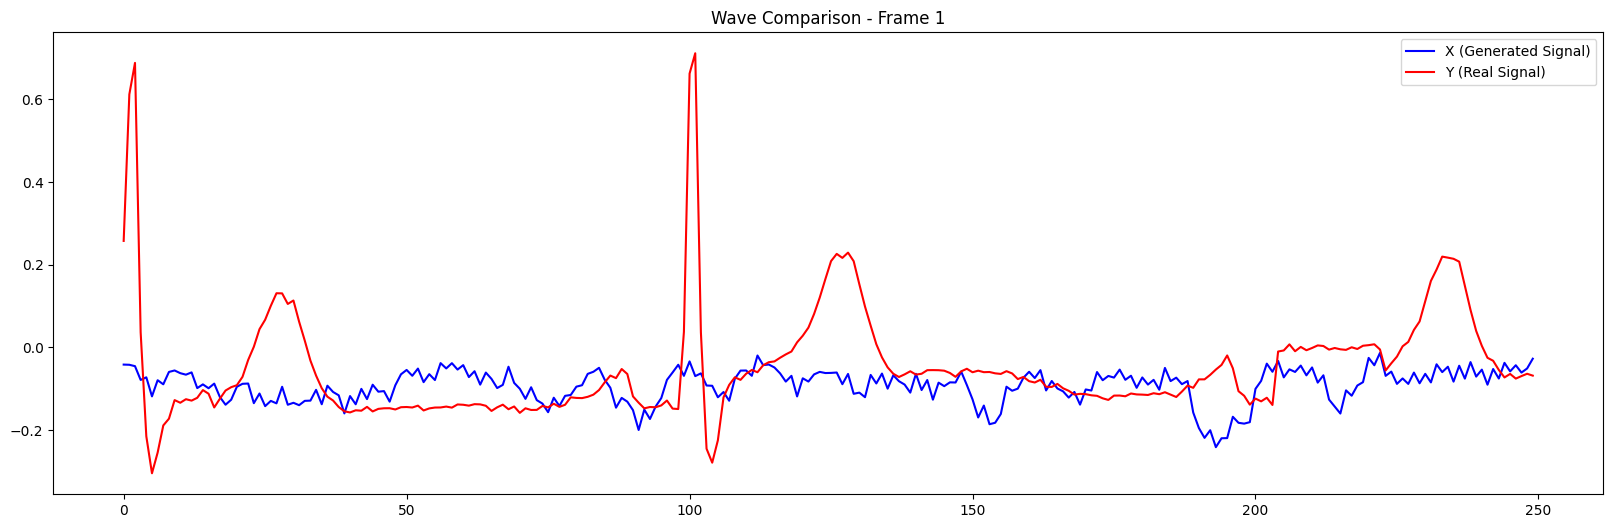

Frame 1:
Mean Squared Error (MSE): 0.0194
Fréchet Distance: 0.7247
Epoch 10/151, Critic Loss: -0.27819451689720154, Generator Loss: -2.6677772998809814
Epoch 11/151, Critic Loss: -1.1964404582977295, Generator Loss: -4.994791030883789
Epoch 12/151, Critic Loss: 0.9574964046478271, Generator Loss: -3.3915822505950928
Epoch 13/151, Critic Loss: 1.0549399852752686, Generator Loss: -10.932418823242188
Epoch 14/151, Critic Loss: -0.7480769753456116, Generator Loss: -11.554046630859375
Epoch 15/151, Critic Loss: 0.0513809472322464, Generator Loss: -11.270854949951172
Epoch 16/151, Critic Loss: 0.5656880140304565, Generator Loss: -0.6659964323043823
Epoch 17/151, Critic Loss: 0.19071760773658752, Generator Loss: -10.722908020019531
Epoch 18/151, Critic Loss: -0.3140243887901306, Generator Loss: -10.85306167602539
Epoch 19/151, Critic Loss: -1.5629814863204956, Generator Loss: -11.095563888549805


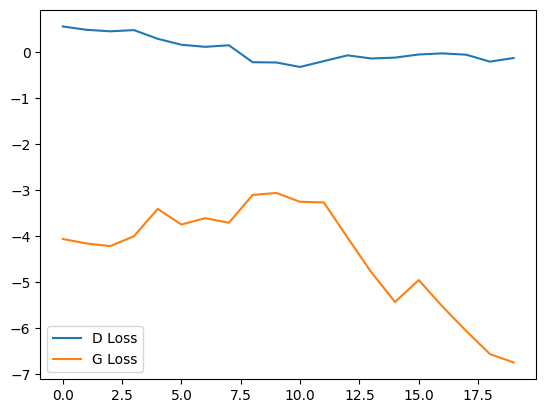

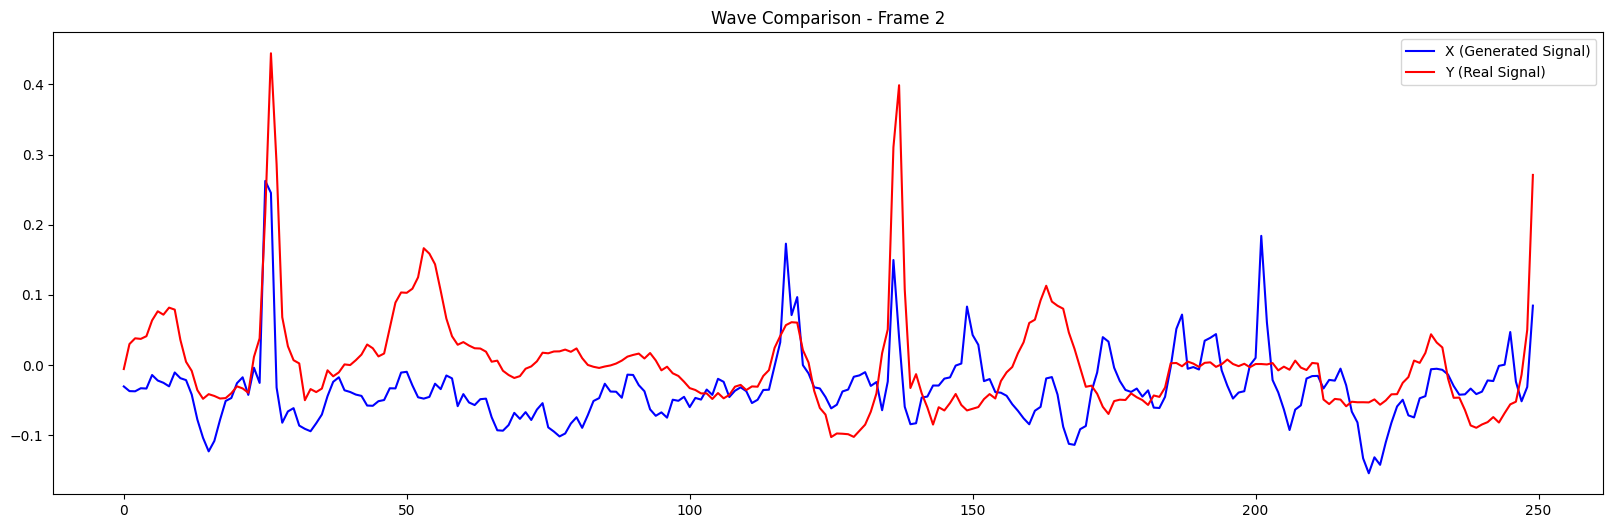

Frame 2:
Mean Squared Error (MSE): 0.0062
Fréchet Distance: 0.1818


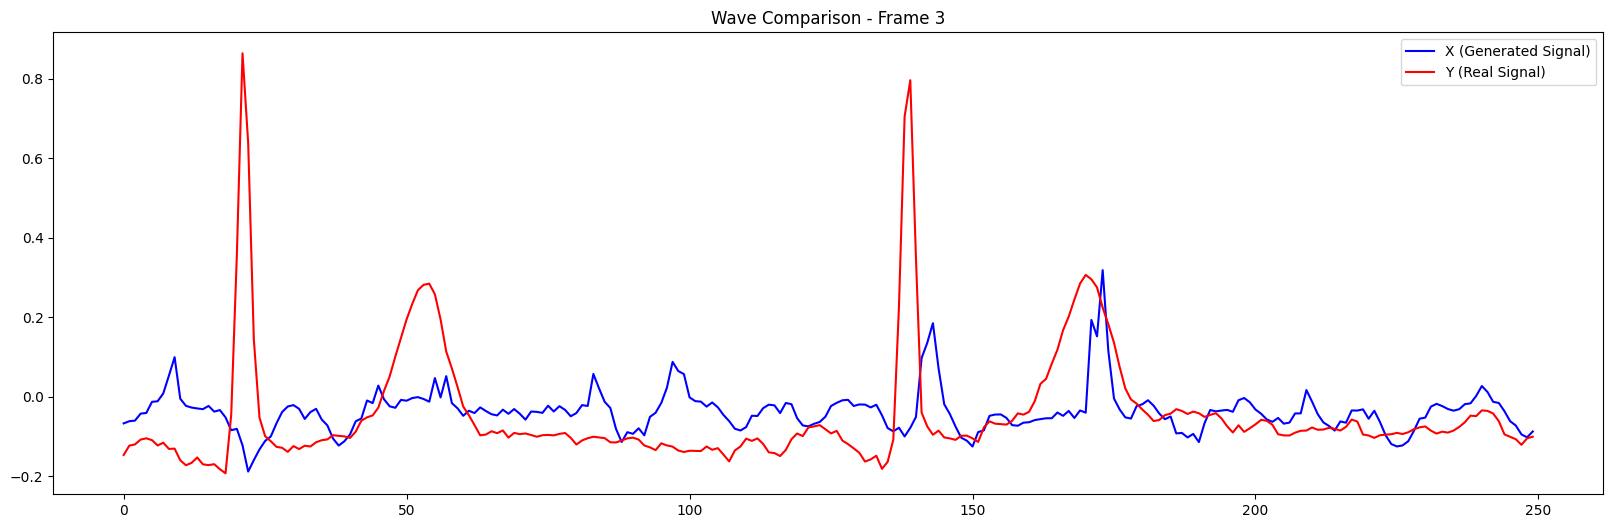

Frame 3:
Mean Squared Error (MSE): 0.0240
Fréchet Distance: 0.5454
Epoch 20/151, Critic Loss: 0.5867742896080017, Generator Loss: -8.401394844055176
Epoch 21/151, Critic Loss: -1.287130355834961, Generator Loss: -5.755974769592285
Epoch 22/151, Critic Loss: 0.23824989795684814, Generator Loss: -11.657034873962402
Epoch 23/151, Critic Loss: -1.4035805463790894, Generator Loss: -17.726552963256836
Epoch 24/151, Critic Loss: 0.17432650923728943, Generator Loss: -9.85527515411377
Epoch 25/151, Critic Loss: 0.35498979687690735, Generator Loss: -6.687097072601318
Epoch 26/151, Critic Loss: 0.27812227606773376, Generator Loss: -14.544063568115234
Epoch 27/151, Critic Loss: 0.042334433645009995, Generator Loss: -11.137073516845703
Epoch 28/151, Critic Loss: -1.0160374641418457, Generator Loss: -8.312782287597656
Epoch 29/151, Critic Loss: 0.12118197977542877, Generator Loss: -13.952160835266113


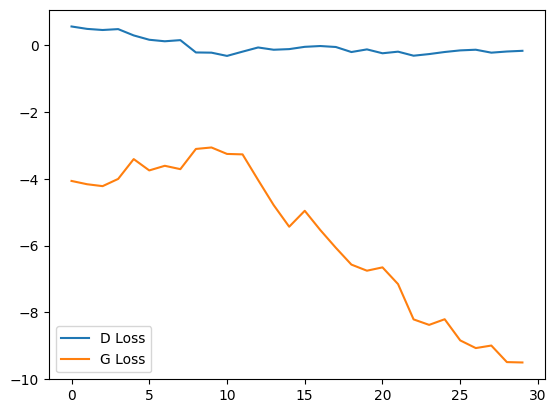

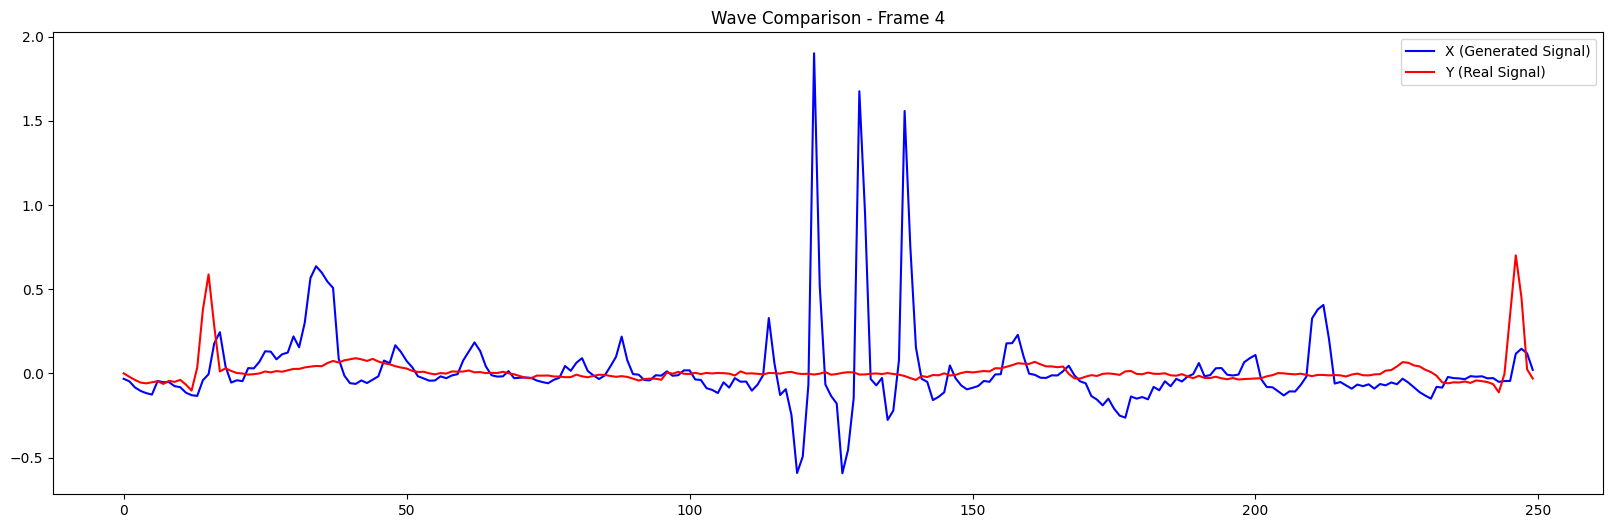

Frame 4:
Mean Squared Error (MSE): 0.0677
Fréchet Distance: 1.1998


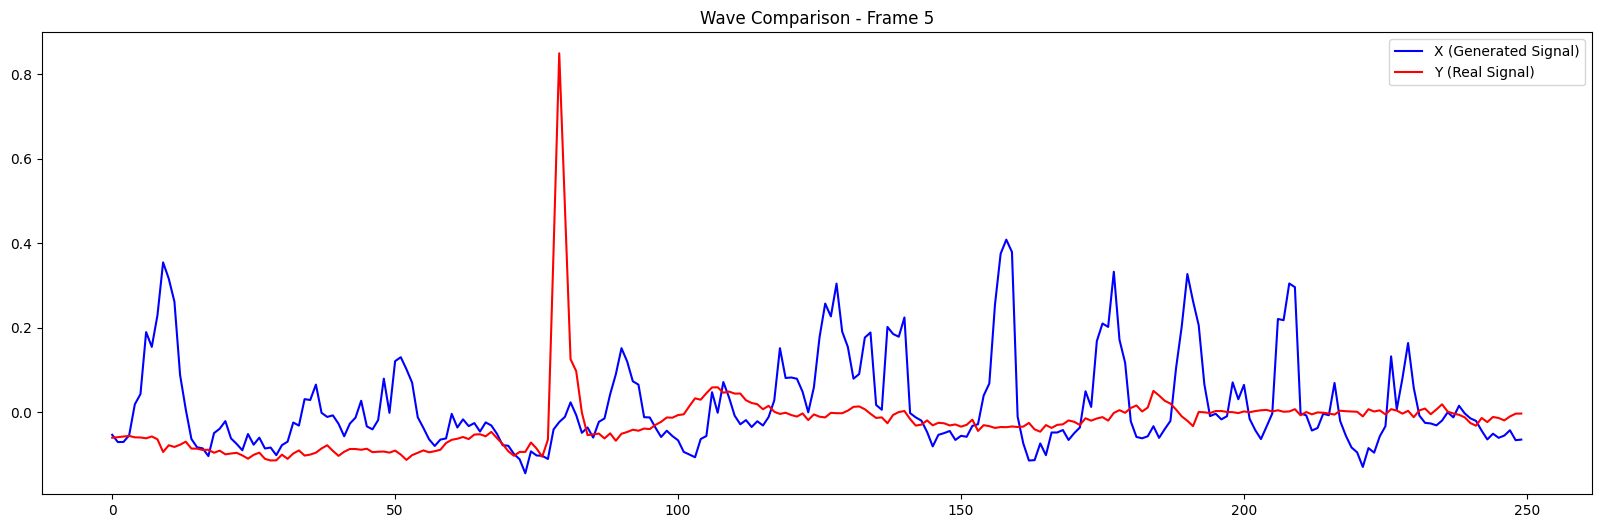

Frame 5:
Mean Squared Error (MSE): 0.0196
Fréchet Distance: 0.4410
Epoch 30/151, Critic Loss: 0.019909368827939034, Generator Loss: -9.602933883666992
Epoch 31/151, Critic Loss: -0.20832926034927368, Generator Loss: -9.095325469970703
Epoch 32/151, Critic Loss: -0.30244308710098267, Generator Loss: -12.380842208862305
Epoch 33/151, Critic Loss: -0.3721795976161957, Generator Loss: -7.217276573181152
Epoch 34/151, Critic Loss: -0.25995466113090515, Generator Loss: -9.977670669555664
Epoch 35/151, Critic Loss: -0.31262868642807007, Generator Loss: -6.3224663734436035
Epoch 36/151, Critic Loss: 0.152475968003273, Generator Loss: -8.045928955078125
Epoch 37/151, Critic Loss: -0.18473543226718903, Generator Loss: -7.372154712677002
Epoch 38/151, Critic Loss: 0.010228447616100311, Generator Loss: -7.615122318267822
Epoch 39/151, Critic Loss: -0.38055339455604553, Generator Loss: -7.417501449584961


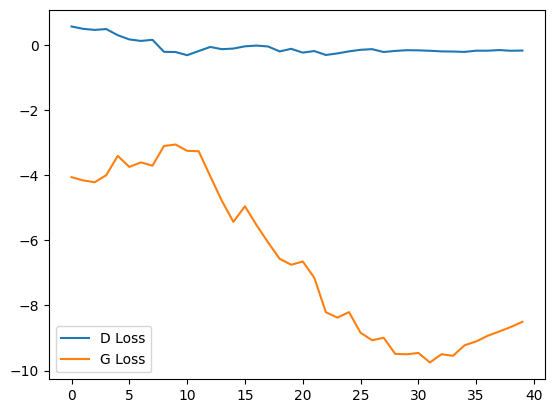

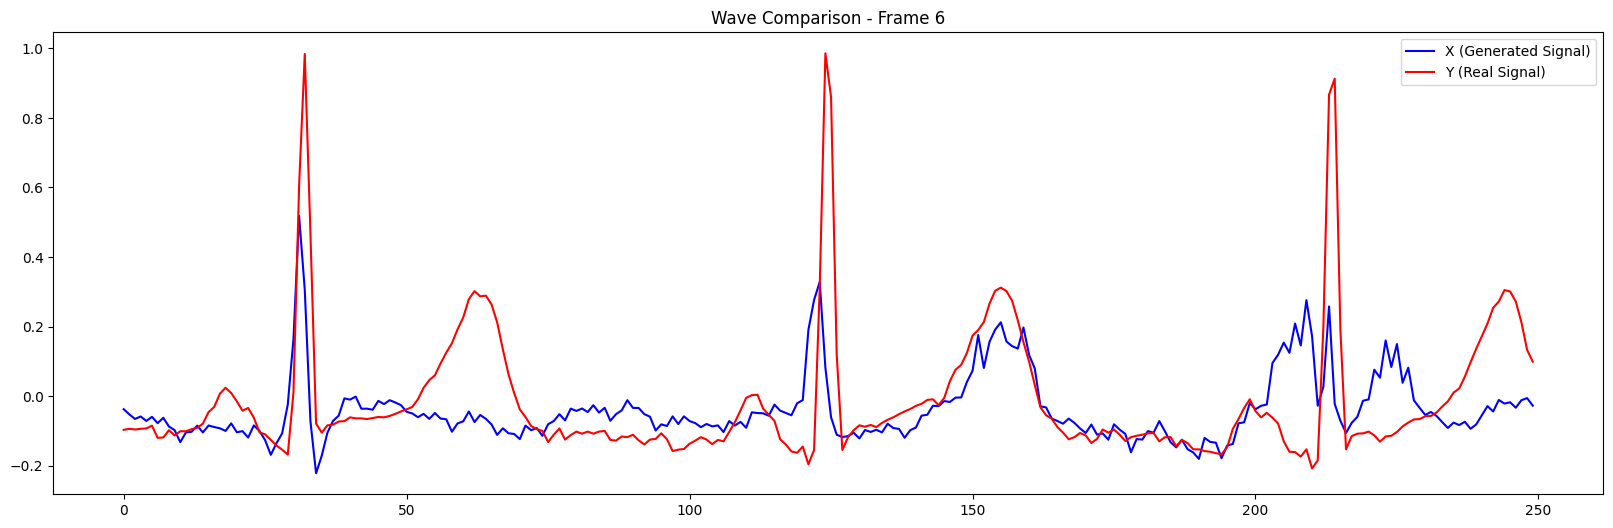

Frame 6:
Mean Squared Error (MSE): 0.0312
Fréchet Distance: 0.4680


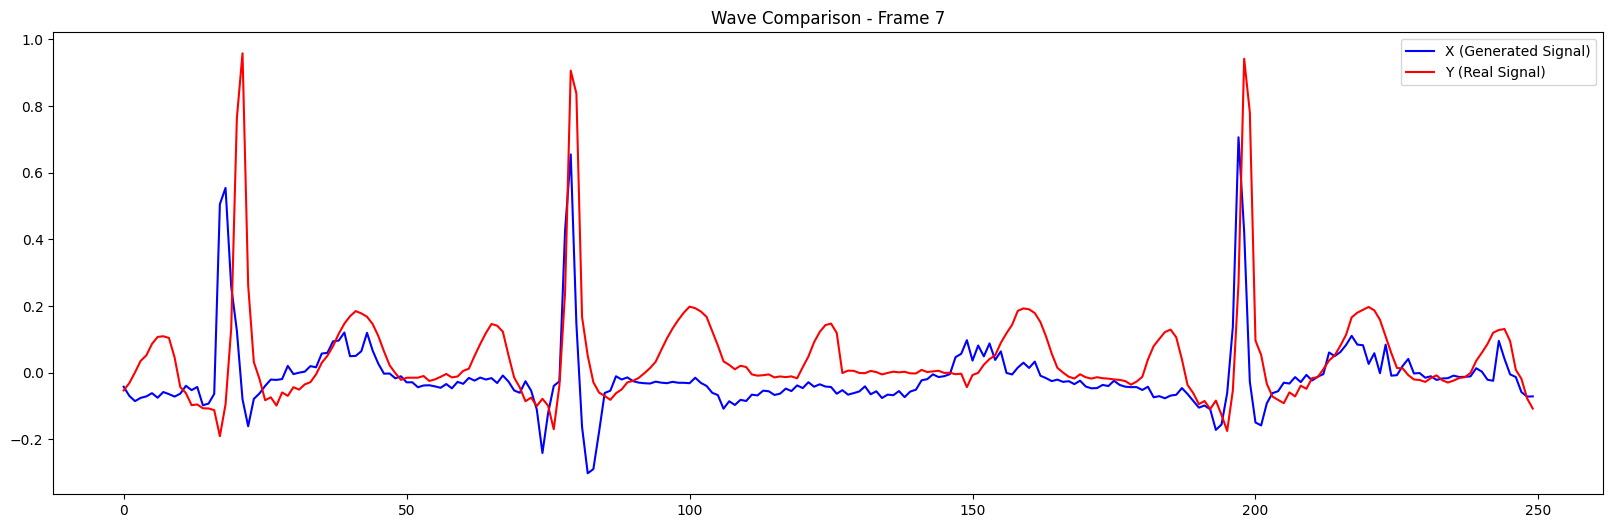

Frame 7:
Mean Squared Error (MSE): 0.0259
Fréchet Distance: 0.2519
Epoch 40/151, Critic Loss: -0.11939451098442078, Generator Loss: -7.075756072998047
Epoch 41/151, Critic Loss: 0.39659583568573, Generator Loss: -9.942890167236328
Epoch 42/151, Critic Loss: -0.4058341085910797, Generator Loss: -3.0032076835632324
Epoch 43/151, Critic Loss: 0.21612997353076935, Generator Loss: -5.571398735046387
Epoch 44/151, Critic Loss: 0.003619684837758541, Generator Loss: -6.221349239349365
Epoch 45/151, Critic Loss: -0.21432265639305115, Generator Loss: -8.35755729675293
Epoch 46/151, Critic Loss: -0.3233654499053955, Generator Loss: -10.87051010131836
Epoch 47/151, Critic Loss: -0.7608829140663147, Generator Loss: -10.611288070678711
Epoch 48/151, Critic Loss: 0.03184666112065315, Generator Loss: -6.520087242126465
Epoch 49/151, Critic Loss: -0.22671476006507874, Generator Loss: -6.341745853424072


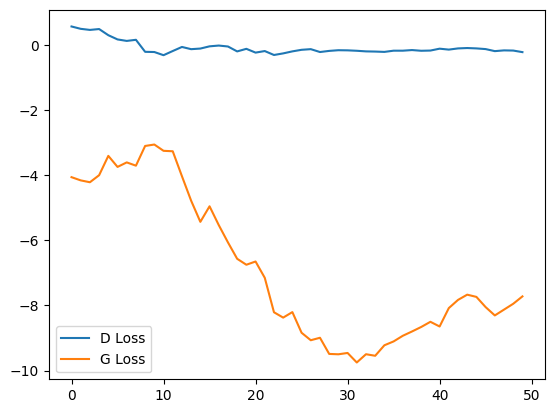

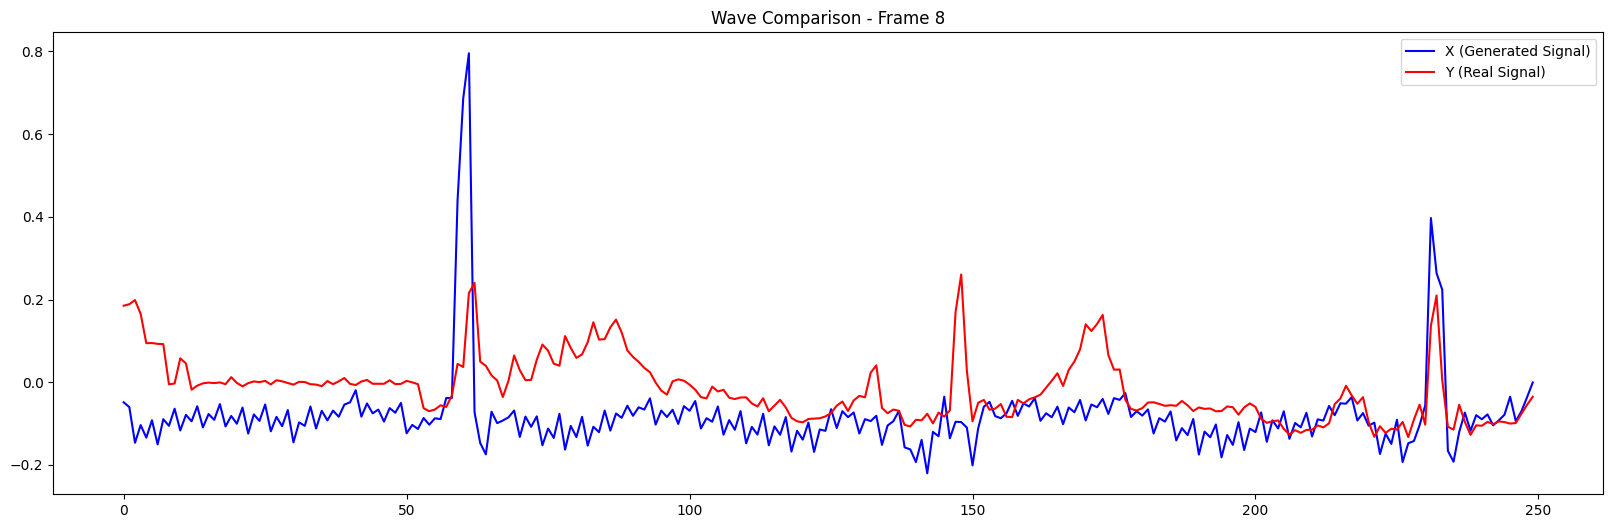

Frame 8:
Mean Squared Error (MSE): 0.0153
Fréchet Distance: 0.5350


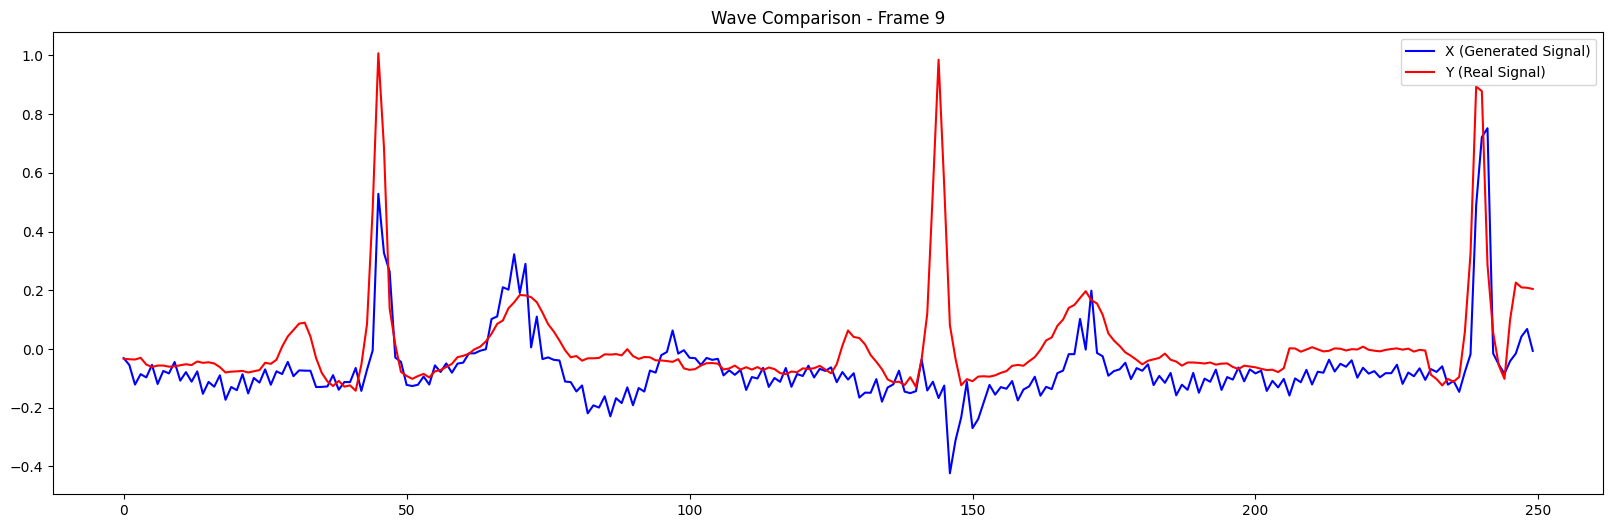

Frame 9:
Mean Squared Error (MSE): 0.0223
Fréchet Distance: 0.2813
Epoch 50/151, Critic Loss: -0.6598793268203735, Generator Loss: -5.685892105102539
Epoch 51/151, Critic Loss: -0.02415262907743454, Generator Loss: -6.417799949645996
Epoch 52/151, Critic Loss: -0.051643889397382736, Generator Loss: -8.364128112792969
Epoch 53/151, Critic Loss: -0.5046554207801819, Generator Loss: -8.069331169128418
Epoch 54/151, Critic Loss: -0.30108171701431274, Generator Loss: -6.3882598876953125
Epoch 55/151, Critic Loss: 0.39412569999694824, Generator Loss: -8.961353302001953
Epoch 56/151, Critic Loss: -0.1339554339647293, Generator Loss: -10.71989631652832
Epoch 57/151, Critic Loss: 0.29094019532203674, Generator Loss: -6.8792948722839355
Epoch 58/151, Critic Loss: 0.01903010904788971, Generator Loss: -9.328974723815918
Epoch 59/151, Critic Loss: -0.16188876330852509, Generator Loss: -11.10478401184082


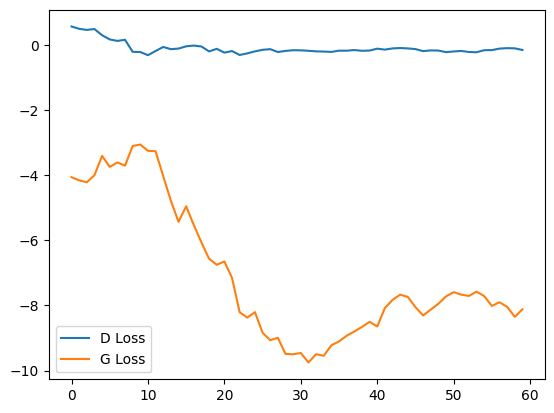

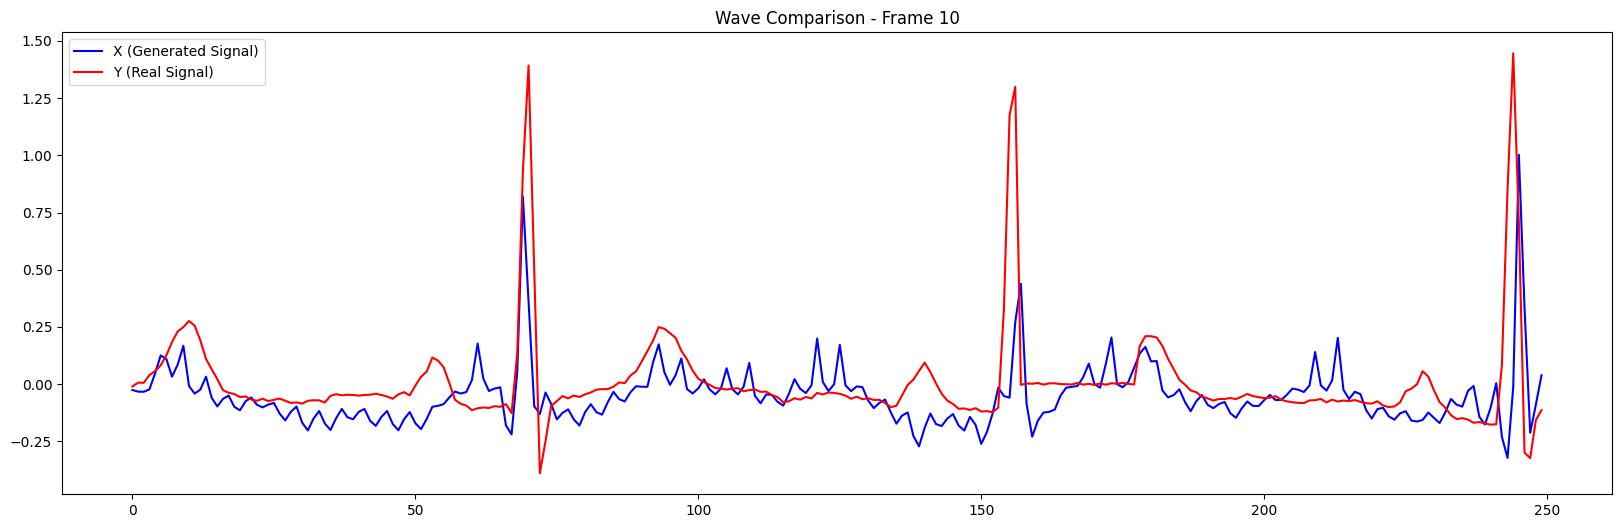

Frame 10:
Mean Squared Error (MSE): 0.0447
Fréchet Distance: 0.4437


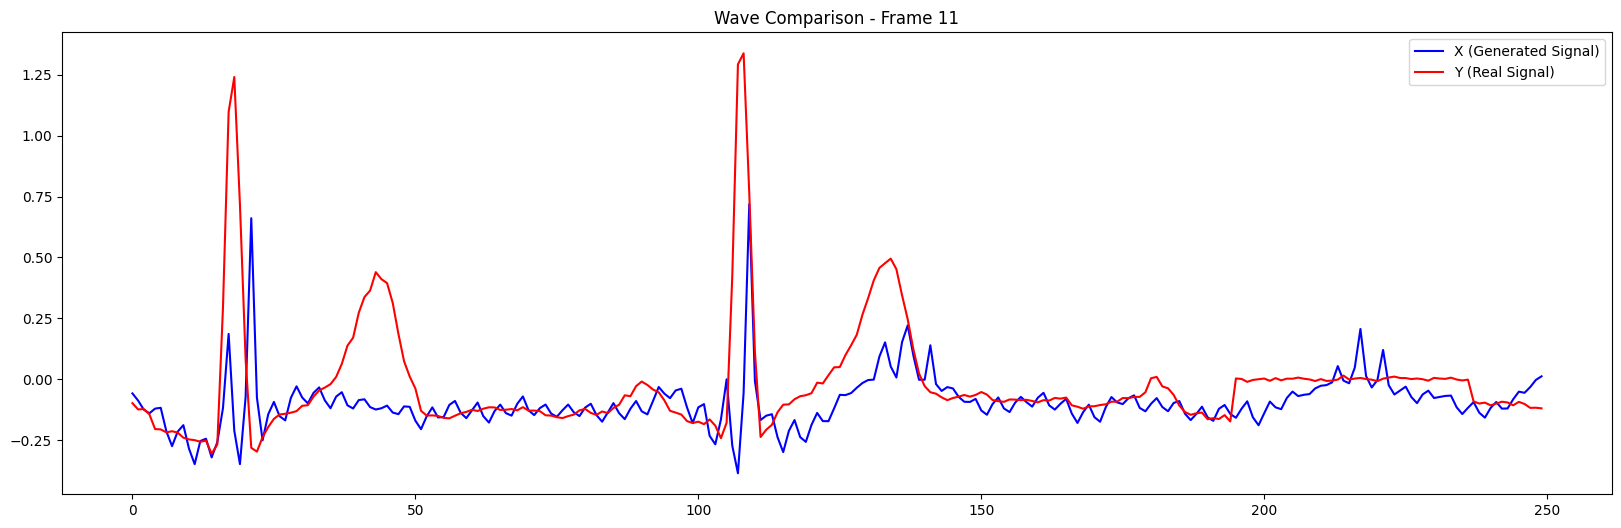

Frame 11:
Mean Squared Error (MSE): 0.0584
Fréchet Distance: 0.6195
Epoch 60/151, Critic Loss: -0.6093721985816956, Generator Loss: -6.044459342956543
Epoch 61/151, Critic Loss: -0.3665906488895416, Generator Loss: -9.790949821472168
Epoch 62/151, Critic Loss: -0.12959040701389313, Generator Loss: -7.1907196044921875
Epoch 63/151, Critic Loss: -0.01418301835656166, Generator Loss: -3.7475688457489014


In [327]:
g_losses, d_losses = [], []
for epoch in range(epochs):
    for real_1, real_2 in dataloader:
        real_1, real_2 = real_1.to(device=device, dtype=torch.float32), real_2.to(device=device, dtype=torch.float32)
        real_2 += 0.01 * torch.randn_like(real_2) #ADDING SOME NOISE
        for _ in range(3):
            optimizer_c.zero_grad()
            noise = torch.randn_like(real_1)
            gen_input = torch.stack([real_1, noise], dim=1)  # (batch, 2, seq_len)
            
            fake_2 = generator(gen_input)
            d_real_input = torch.cat([real_2.unsqueeze(1), real_1.unsqueeze(1)], dim=1)
            d_fake_input = torch.cat([fake_2.detach(), real_1.unsqueeze(1)], dim=1)

            real_scores = critic(d_real_input)
            fake_scores = critic(d_fake_input)  # Detach to avoid generator update
            #gradient_penalty
            
            gradient_penalty = compute_gradient_penalty(critic, real_2.unsqueeze(1), fake_2.detach(), real_1.unsqueeze(1), device)    
            c_loss = torch.mean(fake_scores) - torch.mean(real_scores) + 10*gradient_penalty
            c_loss.backward()
            optimizer_c.step()
            
            # # Clip critic weights
            # for p in critic.parameters():
            #     p.data.clamp_(-clip_value, clip_value)
        
        optimizer_g.zero_grad()
        gen_input = torch.stack([real_1, torch.randn_like(real_1)], dim=1)
        fake_2 = generator(gen_input)
        d_fake_input = torch.cat([fake_2, real_1.unsqueeze(1)], dim=1)
        g_loss = -torch.mean(critic(d_fake_input))
        g_loss.backward()
        optimizer_g.step()
    g_losses.append(g_loss.item())
    d_losses.append(c_loss.item())
    if (epoch+1)%10==0:
        plot_losses(d_losses, g_losses)
        with torch.no_grad():
            for real_1, real_2 in dataloader:   
                real_1, real_2 = real_1.to(torch.float32),real_2.to(torch.float32)
                real_1, real_2 = real_1.to(device), real_2.to(device)
                gen_input = torch.stack([real_1, torch.randn_like(real_1)], dim=1) 
                fake_2 = generator(gen_input)
                counter = plotWave(fake_2[0],real_2[0], counter)
                counter = plotWave(fake_2[12],real_2[12], counter) #random output
                break
    print(f"Epoch {epoch+1}/{epochs}, Critic Loss: {c_loss.item()}, Generator Loss: {g_loss.item()}")


In [ ]:
# #ONLY c-GAN training loop
# criterion = nn.BCELoss()
# g_losses, d_losses = [], []
# for epoch in range(epochs):
#     for real_1, real_2 in dataloader:
#         real_1, real_2 = real_1.to(device=device, dtype=torch.float32), real_2.to(device=device, dtype=torch.float32)
#         #real_2 += 0.01 * torch.randn_like(real_2)  # Noise augmentation
#         # Train Discriminator
#         optimizer_d.zero_grad()
#         # Generate noise and condition
        
#         noise = torch.randn_like(real_1)
#         gen_input = torch.stack([real_1, noise], dim=1)  # (batch, 2, seq_len)
#         fake_2 = generator(gen_input)
#         # Real and fake inputs for discriminator
#         d_real_input = torch.cat([real_2.unsqueeze(1), real_1.unsqueeze(1)], dim=1)
#         d_fake_input = torch.cat([fake_2.detach(), real_1.unsqueeze(1)], dim=1)

#         # Discriminator loss
#         real_labels = torch.ones(real_1.size(0), 1, device=device)
#         fake_labels = torch.zeros(real_1.size(0), 1, device=device)
#         d_real_loss = criterion(discriminator(d_real_input), real_labels)
#         d_fake_loss = criterion(discriminator(d_fake_input), fake_labels)
#         d_loss = (d_real_loss + d_fake_loss)/2
#         d_loss.backward()
#         optimizer_d.step()

#         # Train Generator
#         optimizer_g.zero_grad()
#         gen_input = torch.stack([real_1, torch.randn_like(real_1)], dim=1)
#         fake_2 = generator(gen_input)
#         d_fake_input = torch.cat([fake_2, real_1.unsqueeze(1)], dim=1)
#         g_loss = 0.9*criterion(discriminator(d_fake_input), real_labels)  + 0.1 * l1_loss(fake_2, real_2)
#         g_loss.backward()
#         optimizer_g.step()
#     g_losses.append(g_loss.item())
#     d_losses.append(d_loss.item())
#     if (epoch+1)%50==0:
#         plot_losses(d_losses, g_losses)
#         with torch.no_grad():
#             for real_1, real_2 in dataloader:   
#                 real_1, real_2 = real_1.to(torch.float32),real_2.to(torch.float32)
#                 real_1, real_2 = real_1.to(device), real_2.to(device)
#                 gen_input = torch.stack([real_1, torch.randn_like(real_1)], dim=1) 
#                 fake_2 = generator(gen_input)
#                 counter = plotWave(fake_2[0],real_2[0], counter)
#                 counter = plotWave(fake_2[12],real_2[12], counter) #random output
#                 break
#     print(f"Epoch {epoch+1}/{epochs}, Discrimiator Loss: {d_loss.item()}, Generator Loss: {g_loss.item()}")

Epoch 1/151, Discrimiator Loss: 0.3402656018733978, Generator Loss: 2.1275439262390137
Epoch 2/151, Discrimiator Loss: 0.08739927411079407, Generator Loss: 6.106816291809082


KeyboardInterrupt: 

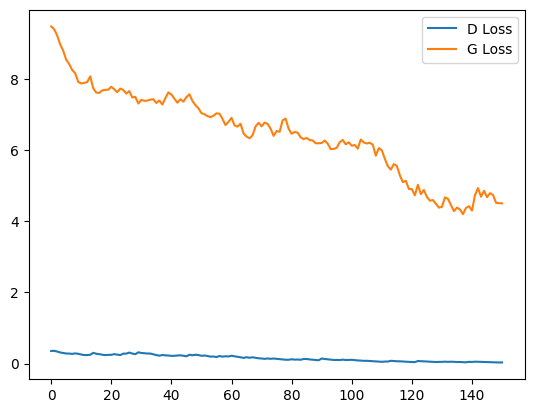

In [ ]:
g_losses_new = []
for l in g_losses:
    g_losses_new.append(10.0-l)
plot_losses(d_losses, g_losses_new)

In [ ]:
#save model
torch.save(generator.state_dict(), 'generator-STFT-7.pth')

In [ ]:
def get_metrics(ecg_tensors, fs=100):
    rr = []
    qrs = []
    qt = []
    st = []
    ecg_tensors = ecg_tensors.view(32, 250)
    for ecg_tensor in ecg_tensors:
        ecg_tensor = torch.concat([ecg_tensor, ecg_tensor], dim=0)
        ecg_np = ecg_tensor.detach().cpu().squeeze().numpy()
        
        if len(ecg_np) < 500:
            raise ValueError("ECG length too short. Needs at least 500 samples (~5s at 100Hz).")

        _, info = nk.ecg_process(ecg_np, sampling_rate=fs)

        r_peaks = list(info.get("ECG_R_Peaks", []))
        q_peaks = list(info.get("ECG_Q_Peaks", []))
        s_peaks = list(info.get("ECG_S_Peaks", []))
        t_onsets = list(info.get("ECG_T_Onsets", []))
        t_offsets = list(info.get("ECG_T_Offsets", []))
        while r_peaks and r_peaks[-1] > 250:
            r_peaks.pop()
        while q_peaks and q_peaks[-1] > 250:
            q_peaks.pop()
        while s_peaks and s_peaks[-1] > 250:
            s_peaks.pop()
        while t_onsets and t_onsets[-1] > 250:
            t_onsets.pop()
        while t_offsets and t_offsets[-1] > 250:
            t_offsets.pop()
        rr_intervals = np.diff(r_peaks) / fs if len(r_peaks) >= 2 else []
        qrs_durations = [(s - q) / fs for q, s in zip(q_peaks, s_peaks)] if q_peaks and s_peaks else []
        qt_intervals = [(to - q) / fs for q, to in zip(q_peaks, t_offsets)] if q_peaks and t_offsets else []
        st_intervals = [(t - s) / fs for s, t in zip(s_peaks, t_onsets)] if s_peaks and t_onsets else []
        for x in rr_intervals:
            if not np.isnan(x) and x > 0:
                rr.append(x)
        for x in qrs_durations:
            if not np.isnan(x) and x > 0:
                qrs.append(x)
        for x in qt_intervals:
            if not np.isnan(x) and x > 0:
                qt.append(x)
        for x in st_intervals:
            if not np.isnan(x) and x > 0:
                st.append(x)
    return {
        "RR_intervals": np.mean(rr) if rr else [],
        "QRS_durations": np.mean(qrs) if qrs else [],
        "QT_intervals": np.mean(qt) if qt else [],
        "ST_intervals": np.mean(st) if st else []
    }


In [ ]:
get_metrics(fake_2, fs=100)

/Users/pratyushgaurav/Documents/BiometricByPass/.venv/lib/python3.13/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


ValueError: cannot convert float NaN to integer

(torch.Size([32, 1, 250]), torch.Size([32, 250]))

{'RR_intervals': np.float64(0.8613725490196077), 'QRS_durations': np.float64(0.1127848101265823), 'QT_intervals': np.float64(0.34524999999999995), 'ST_intervals': np.float64(0.12779220779220776)} {'RR_intervals': np.float64(0.8020370370370371), 'QRS_durations': np.float64(0.1278048780487805), 'QT_intervals': np.float64(0.35473684210526324), 'ST_intervals': np.float64(0.12723684210526318)}


ValueError: The truth value of an empty array is ambiguous. Use `array.size > 0` to check that an array is not empty.

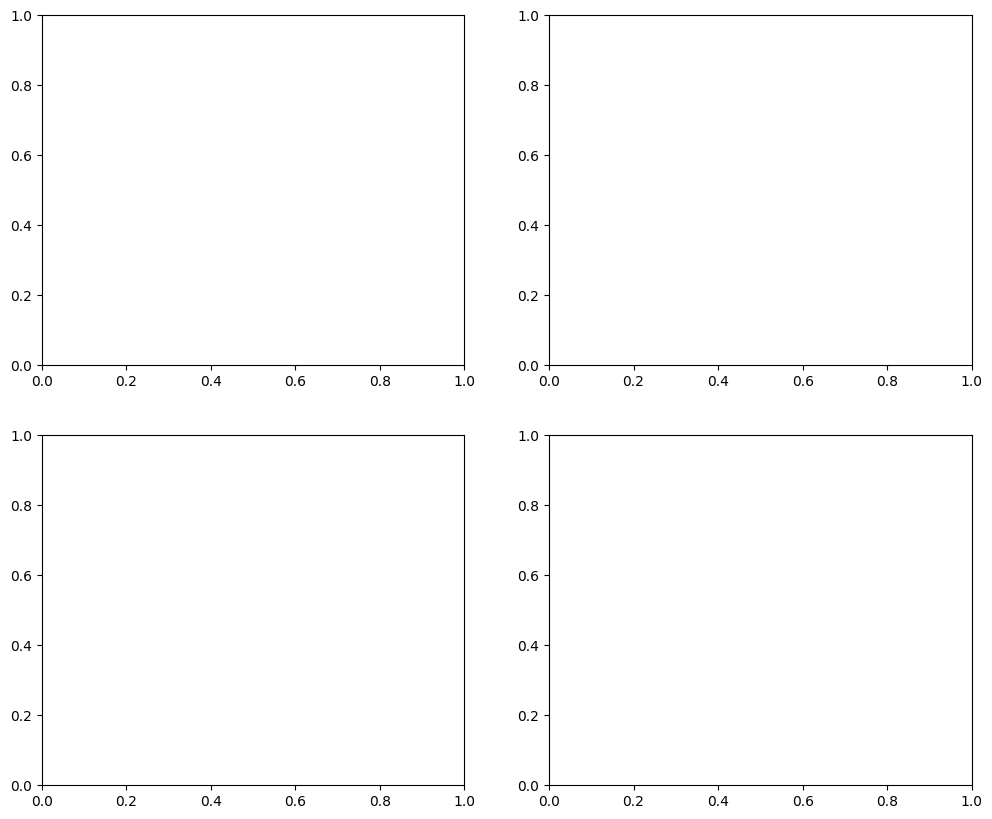

In [ ]:

def bland_altman_plot(data1, data2, title="Bland-Altman Plot", ylabel="Difference", ax=None):
    data1 = np.array(data1)
    data2 = np.array(data2)
    means = (data1 + data2) / 2
    diffs = data1 - data2
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)

    if ax is None:
        fig, ax = plt.subplots()

    ax.scatter(means, diffs, alpha=0.6)
    ax.axhline(mean_diff, color='gray', linestyle='--', label='Mean Diff')
    ax.axhline(mean_diff + 1.96*std_diff, color='red', linestyle='--', label='+1.96 SD')
    ax.axhline(mean_diff - 1.96*std_diff, color='red', linestyle='--', label='-1.96 SD')
    ax.set_title(title)
    ax.set_xlabel('Mean of Real and Fake')
    ax.set_ylabel(ylabel)
    ax.legend()
    return ax

fake_metrics = get_metrics(fake_2, fs=100)
real_metrics = get_metrics(real_2, fs=100)

keys = ["RR_intervals", "QRS_durations", "QT_intervals", "ST_intervals"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

print(fake_metrics, real_metrics)

for i, key in enumerate(keys):
    fake_val = fake_metrics[key]
    real_val = real_metrics[key]
    if fake_val != [] and real_val != []:
        bland_altman_plot([real_val], [fake_val], title=f"{key} - Bland-Altman", ylabel=f"{key} Diff", ax=axs[i])
    else:
        axs[i].text(0.5, 0.5, 'Insufficient Data', ha='center', va='center')
        axs[i].set_title(f"{key} - Bland-Altman")
        axs[i].axis('off')

plt.tight_layout()
plt.show()
